In [2]:
import sys
import os
import json
import shutil

from typing import List, Dict
from datetime import datetime
from hashlib import md5

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


sys.path.insert(0, '/home/jovyan/volcano-anomaly/notebook_pges')
from data_utils import *
from viz_utils import *
from lstm_obj import lstm

## Defining your job inputs

The following cell is tagged with "parameters", which allows papermill to identify the cell containing per-run parameters
Cell tags may be accessed using the double-gear icon in JupyterLab's left-hand gutter.

All variables defined in the following cell are treated as job input parameters, and will be accessible through the `_context.json` file at runtime.

For more information, visit https://papermill.readthedocs.io/en/latest/

In [3]:
# Job input parameters
mintpy_input_dataset_id: str = 'S1-TIMESERIES-MINTPY-A124-20190214-718d4'
central_pixel_x: int = 500
central_pixel_y: int = 500
active_range_distance: int = 12
outer_range_distance: int = 24
lstm_grid_size: int = 3
lstm_time_window: int = 9

# PCM-System Parameters
# These use reserved-prefix parameter names (_*) and are also parsed during `notebook-pge-wrapper specs` to generate the hysds-io and job-spec
_time_limit = 57389
_soft_time_limit = 4738
_disk_usage = "10GB"
_submission_type = "individual"
_required_queue = "factotum-job_worker-small"
_label = "Volcano Anomaly LSTM"

In [ ]:
lstm_grid_size = int(lstm_grid_size)
lstm_time_window = int(lstm_time_window)

## Utility functions

In [4]:

def get_pixel_range(central_pixel: int, distance: int):
    return (central_pixel - distance, central_pixel + distance)

## Defining your process

The following cell contains trivial stubbed function examples as might be used in a job execution flow.

Generally, a job consists of retrieving some data based on the job's arguments, processing it somehow, and writing the output to one or more files.

In [5]:
def retrieve_data(input_dataset_id: str) -> str:
    """Returns the filename """
    from urllib.parse import urlparse
    from pele.lib.client import PeleRequests

    mozart_host = '137.78.250.114'
    base_url = f'https://{mozart_host}/pele/api/v0.1'
    pr = PeleRequests(base_url, verify=False)

    r = pr.get(f'{base_url}/pele/dataset/{input_dataset_id}')#, params={'echo_str': 'hello world'})

    assert r.status_code == 200
    
    product_directory_web_url = [url for url in r.json().get('result')['urls'] if url.startswith('http://')][0]
    source_file_url = os.path.join(product_directory_web_url, 'timeseries_demErr.h5')
    destination_filepath = os.path.abspath('./timeseries_demErr.h5')
    
    !wget -O {destination_filepath} {source_file_url}
    
    return destination_filepath

def extract(dem_err_filepath, active_range, outer_range, output_dir) -> None:
    print('EXTRACTING TRAINING DATA')
    
    data, dates = read_data(dem_err_filepath)
    training_data = {}

    data_time_steps = data.shape[0] - 1
    data_x_resolution, data_y_resolution = data.shape[1:]

    training_data['area'] = dict()
    training_data['area']['dates'] = dates
    extr_series = extract_training_data(data, active_range, outer_range)

    extr_reshp = []
    for j in range(extr_series.shape[1]):
        for i in range(extr_series.shape[2]):
            serie = extr_series[:, j, i]
            assert (len(dates) == serie.shape[0])
            extr_reshp.append(serie)
    extr_reshp = np.array(extr_reshp)

    plot_data = {'series' : extr_reshp,
                 'dates' : dates,
                 'label' : None,
                 'id' : "sierra negra"}

    # Reshape to 3D format expected by LSTM: [samples, timesteps, features]
    extr_reshp = extr_reshp.reshape(len(dates), len(extr_reshp))
    training_data['area']['series'] = np.expand_dims(extr_reshp, axis=0)

    output_filepath = os.path.join(output_dir, "training_data.png")
    plot_1dseries(plot_data, dates, os.path.abspath(output_filepath))

    pickle.dump(training_data, open('training_data.p', 'wb'))
    

def train_lstm_model(training_data_filepath: str = os.path.abspath('./training_data.p')) -> None:
    print('TRAINING_LSTM_MODEL')
    
    # Load training data
    import pickle
    data = pickle.load(open(training_data_filepath, 'rb'))['area']

    # Build dataset
    dataset = build_dataset({'series' : data['series'], 'dates' : data['dates']})
    trainset, validset = dataset['train'], dataset['test']

    ## Train and validate 
    lstm_obj = lstm(n_in=trainset['diff'].shape[1]-1, 
                    n_out=1, 
                    n_feat=trainset['diff'].shape[2],
                    n_repeat=2)
    lstm_obj.train_and_validate_lstm(trainset['diff'], trainset['raw'],
                                     validset['diff'], validset['raw'])

    print (f"Selected Model Rmse Test Set: {lstm_obj.min_rmse}")
    return lstm_obj

def infer_from_lstm_model(dem_err_filepath, lstm_obj, active_range):
    print('INFERRING_FROM_LSTM_MODEL')

    data, dates = read_data(dem_err_filepath)
    
    # input to lstm is "diffed"
    data_active_raw = crop_volcanodata(data, active_range)
    data_active_diff = np.diff(data_active_raw, axis=0) 
    data_active_raw = data_active_raw[1:, :, :]
    assert (data_active_raw.shape == data_active_diff.shape)

    anomaly_map = build_anomaly_map({'raw' : data_active_raw, 'diff' : data_active_diff}, lstm_obj)
    print (anomaly_map.shape)
    return anomaly_map

def plot_anomalies(dem_err_filepath, anomaly_map, time_window, output_dir):
    print('PRODUCING_ANOMALY_VIZUALISATIONS')
    data, dates = read_data(dem_err_filepath)
    plot_timeseries2d(anomaly_map, dates[time_window+1:], 'Anomaly Maps', os.path.abspath(output_dir))

## Defining your job outputs and metadata files

The following cell contains the functions necessary to create a trivial data product for ingestion into the PCM data product catalog.

These functions should be augmented to include your desired dataset definition data, metadata and job output files

It is also typical to include important fields (e.g. track number, orbit direction and temporal bound timestamps) in the dataset id

In [7]:
working_dir = os.path.abspath(os.curdir)

def generate_dummy_context_file() -> None:
    """When run in HySDS, a _context.json file will be present in the working directory, so this is only necessary for local development"""
    filepath: str = os.path.join(working_dir, '_context.json')
    print(f'Writing dummy context to {filepath}')
    with open(filepath, 'w+') as context_file:
        json.dump({'run_timestamp': datetime.now().isoformat()}, context_file)

def generate_dataset_id(id_prefix: str, context: str) -> str:
    """Generates a globally-unique ID for the data product produced.
    Uniqueness is generally ensured by the context, which will (theoretically) be either unique, or subject to deduplication by HySDS"""
    
    hash_suffix = md5(context.encode()).hexdigest()[0:5]

    job_id = f'{id_prefix}-{datetime.now().isoformat()}-{hash_suffix}'

    print(f'Generated job ID: {job_id}')
    return job_id


def generate_dataset_file(dataset_id: str, **kwargs) -> None:
    """Stores standardized metadata used for indexing products in HySDS GRQ"""
    dataset_definition_filepath: str = os.path.join(working_dir, dataset_id, f'{dataset_id}.dataset.json')
    metadata: dict = {
        'version': kwargs.get('version', 'v1.0'),
    }
    
    optional_fields = [
        'label',
        'location',  # Must adhere to geoJSON "geometry" format
        'starttime',
        'endtime'
    ]
    for field in optional_fields:
        if field in kwargs:
            metadata[field] = kwargs.get(field)
    
    with open(dataset_definition_filepath, 'w+') as dataset_file:
        print(f'Writing to {dataset_definition_filepath}')
        json.dump(metadata, dataset_file)
    
def generate_metadata_file(dataset_id: str, metadata: Dict) -> None:
    """Stores custom metadata keys/values used for indexing products in HySDS GRQ"""
    metadata_filepath: str = os.path.join(working_dir, dataset_id, f'{dataset_id}.met.json')
    with open(metadata_filepath, 'w+') as metadata_file:
        print(f'Writing to {metadata_filepath}')
        json.dump(metadata, metadata_file)
        

        
def generate_data_product(working_dir: str = working_dir, id_prefix: str = 'ON_DEMAND-MY_JOB_TYPE') -> None:
    """Generates metadata/dataset files and packages them in a specially-named directory with the desired job output files, for ingestion into the data product catalog"""
    from glob import glob
    
    context_filepath: str = os.path.join(working_dir, '_context.json') 
    with open(context_filepath) as context_file:
        context: str = context_file.read()
            
    dataset_id: str = generate_dataset_id(id_prefix, context)
    
    data_product_dir = os.path.join(working_dir, dataset_id)
    print(f'Generating data product at {data_product_dir}')
    
    os.mkdir(data_product_dir)
    generate_metadata_file(dataset_id, {'my_metadata_field': 'metadata_value'})
    generate_dataset_file(dataset_id)
    
    print(f'Moving PGE output...')
    shutil.move(os.path.join(working_dir, 'training_data.p'), os.path.join(data_product_dir, 'training_data.p'))
    for filepath in glob(os.path.join(working_dir, '*.png')):
        print(filepath)
        filename = os.path.split(filepath)[-1]
        print(filename)
        shutil.move(filepath, os.path.join(data_product_dir, filename))
        
    
    


## Defining your job's high-level execution flow

The following cell contains a trivial set of procedural calls, which will be run

Writing dummy context to /home/jovyan/volcano-anomaly/notebook_pges/_context.json


/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '137.78.250.114'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '137.78.250.114'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


--2021-05-11 16:59:52--  http://soamc-dev-rs-fwd.s3-website-us-west-2.amazonaws.com/products/S1-TIMESERIES-MINTPY/v1.0/2019/02/14/S1-TIMESERIES-MINTPY-A124-20190214-718d4/timeseries_demErr.h5
Resolving soamc-dev-rs-fwd.s3-website-us-west-2.amazonaws.com (soamc-dev-rs-fwd.s3-website-us-west-2.amazonaws.com)... 52.218.132.202
Connecting to soamc-dev-rs-fwd.s3-website-us-west-2.amazonaws.com (soamc-dev-rs-fwd.s3-website-us-west-2.amazonaws.com)|52.218.132.202|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158869384 (152M) [binary/octet-stream]
Saving to: ‘/home/jovyan/volcano-anomaly/notebook_pges/timeseries_demErr.h5’

100%[======================================>] 158,869,384 33.3MB/s   in 4.6s   

2021-05-11 16:59:57 (32.6 MB/s) - ‘/home/jovyan/volcano-anomaly/notebook_pges/timeseries_demErr.h5’ saved [158869384/158869384]

/home/jovyan/volcano-anomaly/notebook_pges/timeseries_demErr.h5
Saving plotted output to /home/jovyan/volcano-anomaly/notebook_pges/
EXTRAC

/home/jovyan/volcano-anomaly/notebook_pges/data_utils.py:45: RuntimeWarning: Mean of empty slice
  data_strided = np.nanmean(data_strided, axis=(3,4)).reshape(data.shape[0], out_shape[0], out_shape[1])


Selected Model Rmse Test Set: 0.03037982222888089
INFERRING_FROM_LSTM_MODEL
(4, 24, 24)
PRODUCING_ANOMALY_VIZUALISATIONS
Saving 2d plot set to /home/jovyan/volcano-anomaly/notebook_pges/_0.png
Generated job ID: ON_DEMAND-MY_JOB_TYPE-2021-05-11T17:01:02.875144-f6ef8
Generating data product at /home/jovyan/volcano-anomaly/notebook_pges/ON_DEMAND-MY_JOB_TYPE-2021-05-11T17:01:02.875144-f6ef8
Writing to /home/jovyan/volcano-anomaly/notebook_pges/ON_DEMAND-MY_JOB_TYPE-2021-05-11T17:01:02.875144-f6ef8/ON_DEMAND-MY_JOB_TYPE-2021-05-11T17:01:02.875144-f6ef8.met.json
Writing to /home/jovyan/volcano-anomaly/notebook_pges/ON_DEMAND-MY_JOB_TYPE-2021-05-11T17:01:02.875144-f6ef8/ON_DEMAND-MY_JOB_TYPE-2021-05-11T17:01:02.875144-f6ef8.dataset.json
Moving PGE output...
/home/jovyan/volcano-anomaly/notebook_pges/training_data.png
training_data.png
/home/jovyan/volcano-anomaly/notebook_pges/_0.png
_0.png
PGE execution complete!


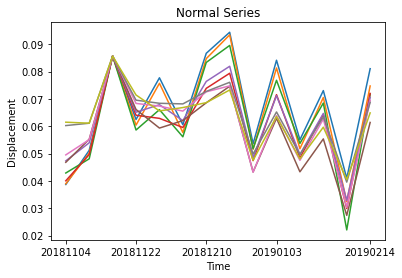

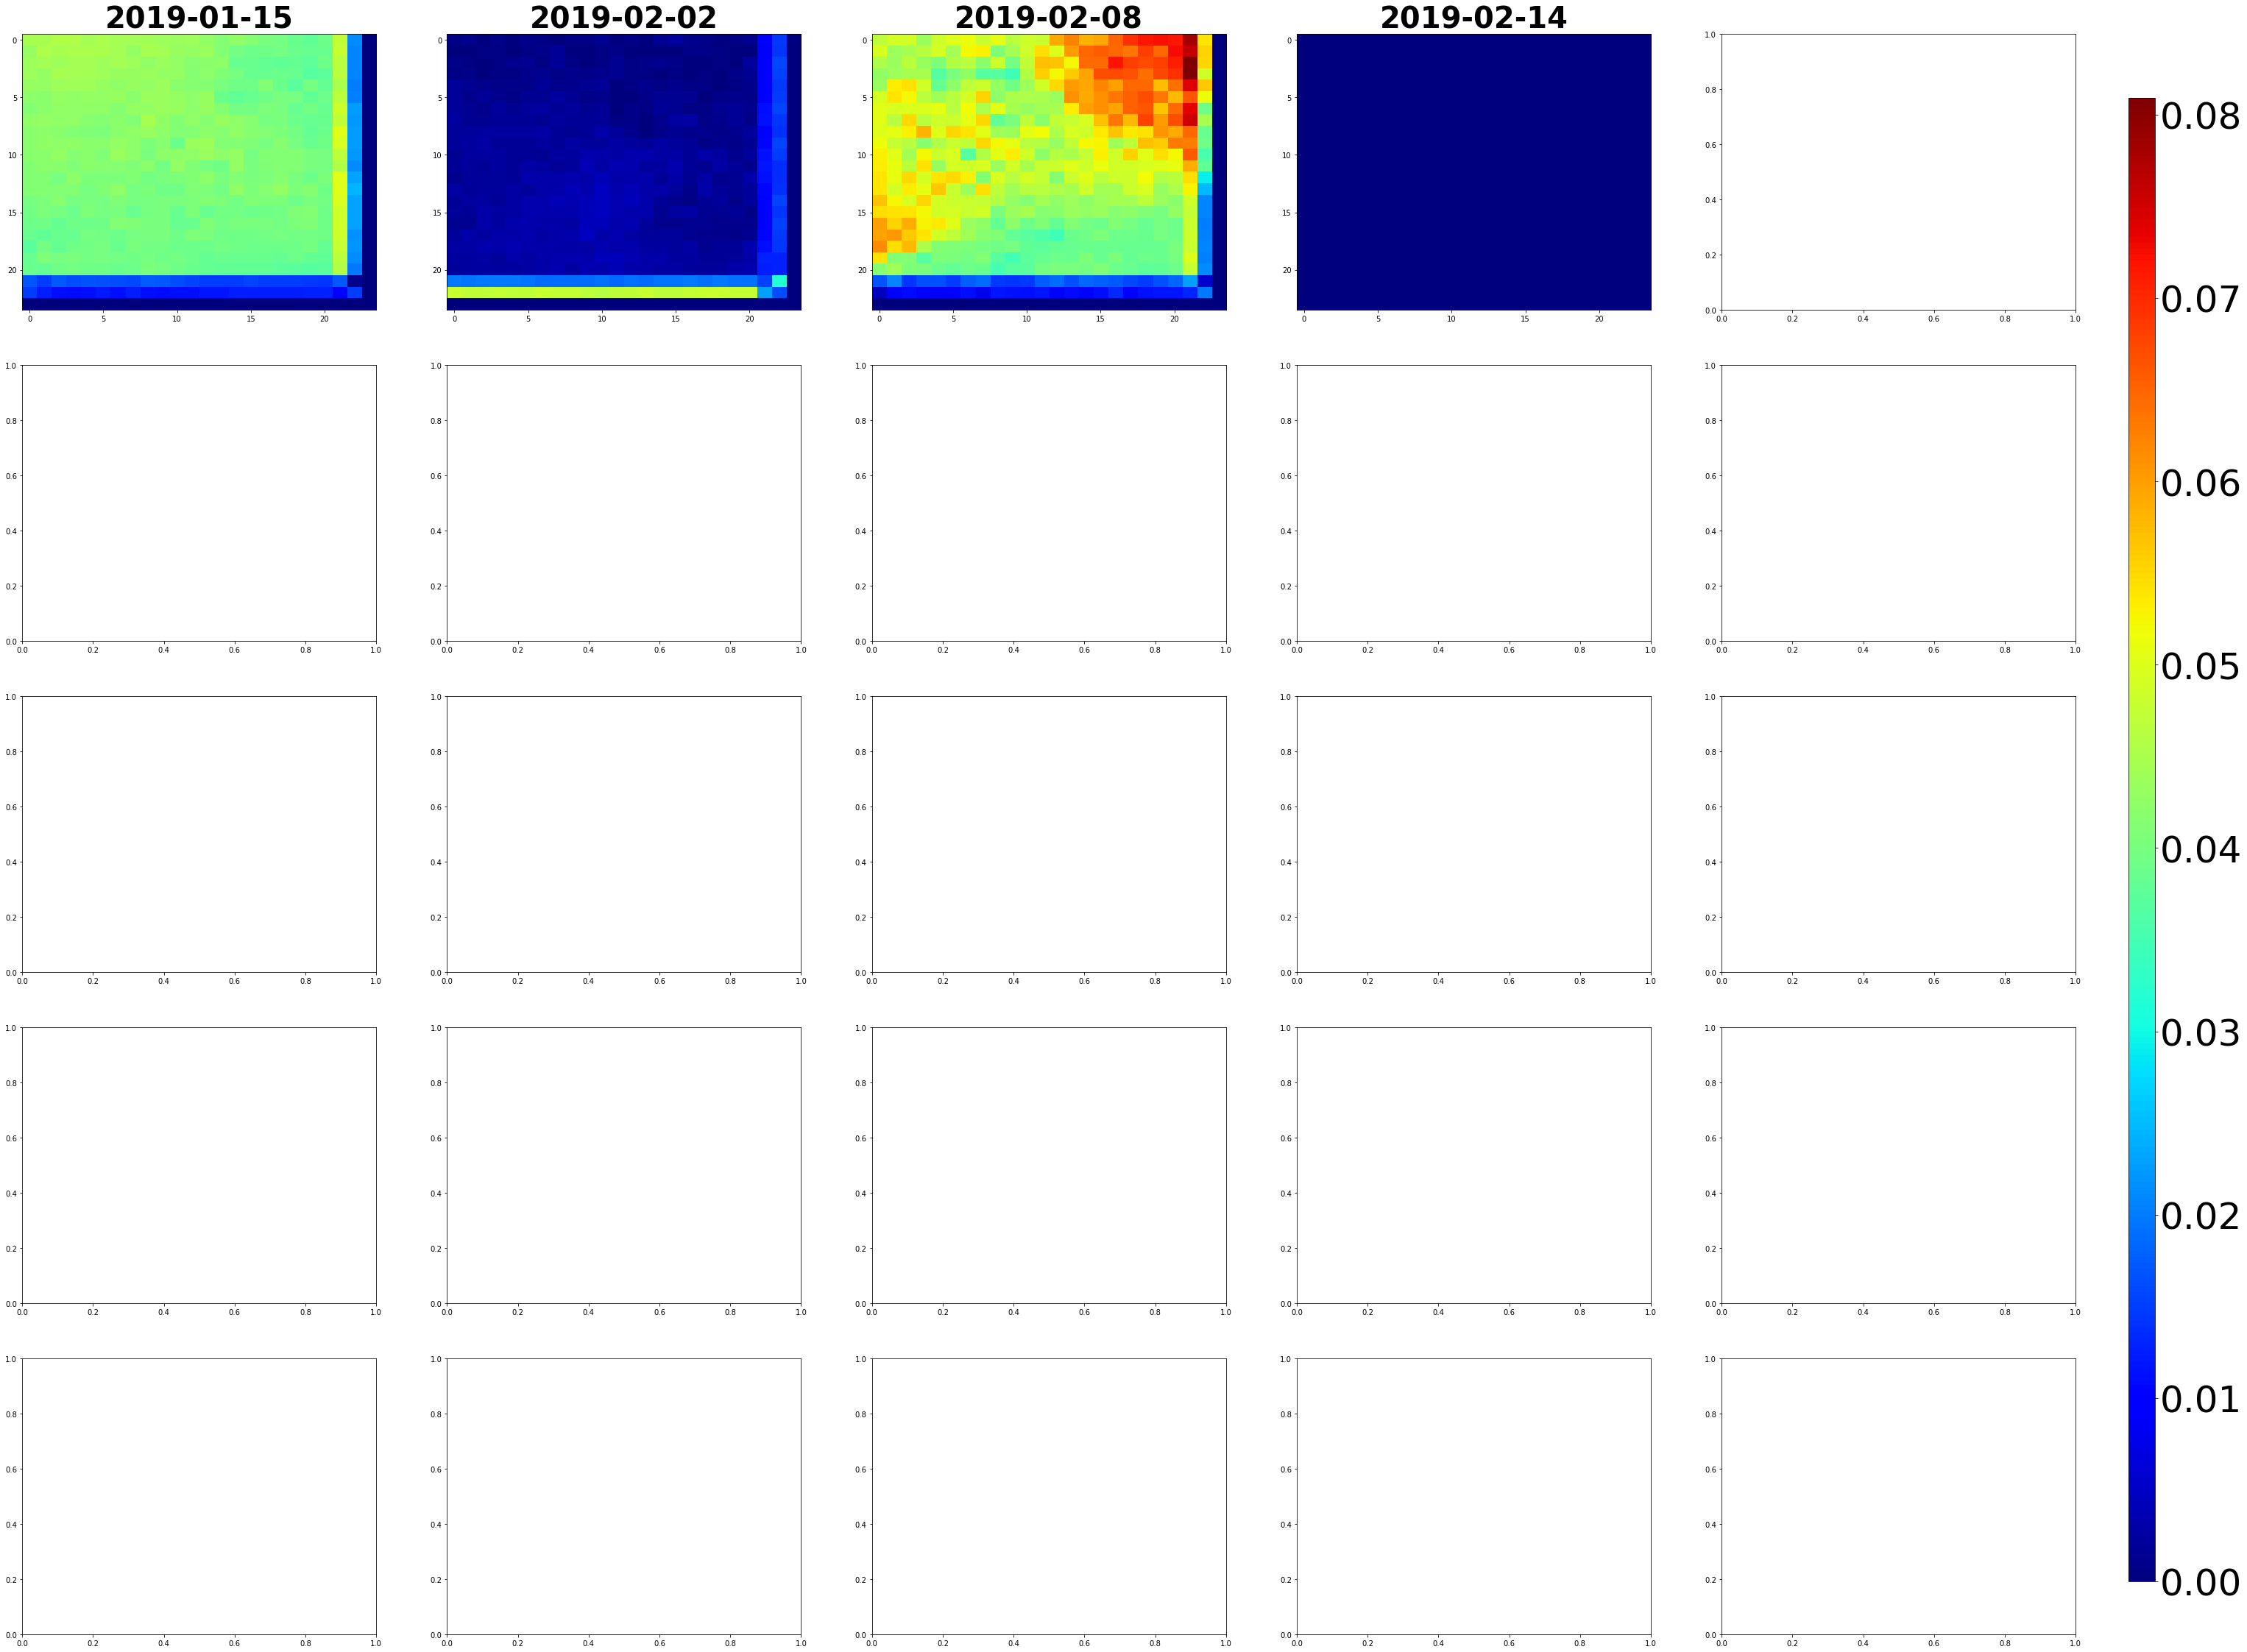

In [8]:
generate_dummy_context_file()

dem_err_filepath =  retrieve_data(mintpy_input_dataset_id)
# dem_err_filepath = '/home/jovyan/volcano_anomaly/notebook_pges/timeseries_demErr.h5'
print(dem_err_filepath)

active_range = get_pixel_range(central_pixel_x, active_range_distance), get_pixel_range(central_pixel_y, active_range_distance) # Coordinates of volcano active region
outer_range  = get_pixel_range(central_pixel_x, outer_range_distance), get_pixel_range(central_pixel_y, outer_range_distance) # Width and Height of this region need to be multiple of the grid size used in function "extract_training_data" (grid_size=3 by default)
assert ((active_range[0][1] - active_range[0][0]) % lstm_grid_size == 0)
assert ((active_range[1][1] - active_range[1][0]) % lstm_grid_size == 0)

output_dir = os.getcwd()
print(f'Saving plotted output to {output_dir}/')

extract(dem_err_filepath, active_range, outer_range, output_dir)
lstm_model = train_lstm_model()
anomaly_map = infer_from_lstm_model(dem_err_filepath, lstm_model, active_range)
plot_anomalies(dem_err_filepath, anomaly_map, lstm_time_window, output_dir)

generate_data_product()

print('PGE execution complete!')
